# Comparative analysis for volumetric versus surface-based source reconstruction

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mne.externals.pymatreader import read_mat
import seaborn as sns
from mne.transforms import apply_trans
import numpy as np
import nibabel as nib
import matplotlib.pylab as plt
import pandas as pd
from scipy.spatial import KDTree
from nibabel.freesurfer.io import read_geometry, write_geometry
import trimesh
import matplotlib as mpl
import matplotlib.cm as cm
import open3d
from pathlib import Path
from mne import create_info
import mne
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from glob import glob
from parse import parse
from tqdm.notebook import tqdm
from itertools import product, combinations
import pyrender
from itertools import product

def plot_values_topomap(value_dict, montage, axes, colorbar=True, cmap='RdBu_r', vmin=None, vmax=None):
    ch_names = list(value_dict.keys())
    info = create_info(ch_names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        RawArray(np.zeros((len(ch_names), 1)), info, copy=None, verbose=False).set_montage(montage)
    
        
    im = plot_topomap(list(value_dict.values()), pos=info, show=False, #image_interp='bilinear',
                     sensors=True, axes=axes, names=info.ch_names, show_names=False,
                     vmin=vmin, vmax=vmax, extrapolate="head")
    if colorbar:
        cbar, cax = _add_colorbar(axes, im[0], cmap, pad=.05,
                                  format='%3.2f')
        cbar.ax.tick_params(labelsize=12)
        #cbar.set_ticks((vmin_, vmax_))    
    
    return im

/home/christian/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Computing sources for volume- and surface-based head models - All in MATLAB, except for source models

### Some code for MATLAB integration

In [2]:
import matlab.engine
import io
from IPython.core.magic import register_cell_magic
ip = get_ipython()

out = io.StringIO()
err = io.StringIO()

# Setup matlab cell magic #
@register_cell_magic
def matlab_magic(line,cell):
    out.truncate(0)
    out.seek(0)
    err.truncate(0)
    err.truncate(0)
    raw = '''{line}.eval("""{cell}""", nargout=0, stdout=out, stderr=err)'''
    ip.run_cell(raw.format(line=line, cell=cell))
    print(out.getvalue())
    print(err.getvalue())

eng = matlab.engine.start_matlab()

### Saving clean ERP data

In [19]:
%%matlab_magic eng

close all
clear all

eeg_files = dir(['/media/christian/seagate/eegip/london/derivatives/lossless/sub-s' ...
                '*/ses-m06/eeg/sub-s*_ses-m06_eeg_qcr.set']);

for no_file=1:length(eeg_files)
    subject = eeg_files(no_file).name(6:8);

    EEG = pop_loadset('filename', [eeg_files(no_file).folder '/' eeg_files(no_file).name]);
    EEG = eeg_checkset(EEG);
    %purge all channels, time, and components that were flagged...
    EEG = pop_marks_select_data(EEG, 'channel marks',[],'labels',{'manual', 'rank'}, 'remove','on');
    EEG = pop_marks_select_data(EEG, 'time marks', [], 'labels', {'manual'}, 'remove', 'on');
    EEG = pop_marks_select_data(EEG, 'component marks', [], 'labels', {'manual'}, 'remove', 'on');


    filename = ['sub-s' subject '_ses-m06_eeg_cleaned.set'];
    pop_saveset(EEG, 'filename', filename);
    
    % cfg = [];
    % cfg.badchannel     = artif.badchannel;
    % cfg.method         = 'weighted';
    % cfg.neighbours     = neighbours;
    % data_fixed = ft_channelrepair(cfg,data);
    
    cfg                         = [];
    cfg.dataset                 = filename;
    cfg.trialfun                = 'ft_trialfun_general'; % this is the default
    cfg.trialdef.eventtype      = 'trigger';
    cfg.trialdef.prestim        = 0.2; % in seconds
    cfg.trialdef.poststim       = 0.8; % in seconds

    try
        cfg.trialdef.eventvalue     = {'Nois'};
        cfg_noise = ft_definetrial(cfg);

        cfg.trialdef.eventvalue     = {'dyn1', 'dyn2', 'dyn3', 'dynO', 'sta1', 'sta2', 'sta3'};
        cfg_faces = ft_definetrial(cfg);
    catch
        continue
    end    

    %% Dealing with discontinuities
    starts = [];
    ends = [];
    for noevent=1:length(cfg_noise.event)
        if strcmp(cfg_noise.event(noevent).value, 'boundary')
            starts = [starts; cfg_noise.event(noevent).sample];
            ends = [ends; cfg_noise.event(noevent).sample + 1];
        end
    end
    cfg_noise.artfctdef.reject          = 'complete';
    cfg_noise.artfctdef.jump.artifact   = [starts ends];
    cfg_noise = ft_rejectartifact(cfg_noise);
    
    starts = [];
    ends = [];
    for noevent=1:length(cfg_faces.event)
        if strcmp(cfg_faces.event(noevent).value, 'boundary')
            starts = [starts; cfg_faces.event(noevent).sample];
            ends = [ends; cfg_faces.event(noevent).sample + 1];
        end
    end    
    cfg_faces.artfctdef.reject          = 'complete';
    cfg_faces.artfctdef.jump.artifact   = [starts ends];
    cfg_faces = ft_rejectartifact(cfg_faces);      
    
    cfg_noise.lpfilter        = 'no';     
    cfg_noise.demean          = 'yes';
    cfg_noise.baselinewindow  = [-0.2 0];
    data_noise = ft_preprocessing(cfg_noise);

    cfg_noise.lpfilter        = 'no';     
    cfg_faces.demean          = 'yes';
    cfg_faces.baselinewindow  = [-0.2 0];
    data_faces = ft_preprocessing(cfg_faces);

    selchan = ft_channelselection({'all' '-Cz'}, data_faces.label);
    cfg = [];
    cfg.channel = selchan;

    data_noise = ft_selectdata(cfg, data_noise);
    data_faces = ft_selectdata(cfg, data_faces);

    %% ERP
    cfg = [];
    cfg.covariance = 'yes';
    cfg.covariancewindow = [-0.2 0]; %it will calculate the covariance matrix
                                   % on the timepoints that are
                                   % before the zero-time point in the trials
    cfg.keeptrials = 'yes';

    tlck_noise = ft_timelockanalysis(cfg, data_noise);
    tlck_faces = ft_timelockanalysis(cfg, data_faces);

    save(['tlck_' subject '_noise.mat'], 'tlck_noise');
    save(['tlck_' subject '_faces.mat'], 'tlck_faces');
end

pop_loadset(): loading file /media/christian/seagate/eegip/london/derivatives/lossless/sub-s602/ses-m06/eeg/sub-s602_ses-m06_eeg_qcr.set ...
Reading float file '/media/christian/seagate/eegip/london/derivatives/lossless/sub-s602/ses-m06/eeg/sub-s602_ses-m06_eeg_qcr.fdt'...
INFO:	2020-10-20T18:50:53	0.022895	0.007894	eeg_checkset:999:	Scaling components to RMS microvolt

INFO:	2020-10-20T18:50:53	0.241302	0.214320	eeg_checkset:999:	Scaling components to RMS microvolt

Removing 22 channel(s)...
INFO:	2020-10-20T18:50:54	0.788691	0.543082	eeg_checkset:999:	Scaling components to RMS microvolt

INFO:	2020-10-20T18:50:54	0.880074	0.088824	eeg_checkset:594:	Event resorted by increasing latencies.

INFO:	2020-10-20T18:50:54	0.912055	0.014829	eeg_checkset:999:	Scaling components to RMS microvolt

eeg_insertbound(): 24 boundary (break) events added.
eeg_insertbound(): event latencies recomputed and 274 events removed.
INFO:	2020-10-20T18:50:54	1.370813	0.456713	eeg_checkset:999:	Scaling componen

### Compute head model - BEM

In [ ]:
%%matlab_magic eng

clear all
close all

template_models = {'3-0Months', '4-5Months', '6-0Months', '7-5Months', ... 
                   '9-0Months', '12-0Months', '2-0Years' };
               
for no_template=1:length(template_models)
    
    %% Load surfaces
    subject_dir = ['/usr/local/freesurfer/subjects/ANTS' template_models{no_template} '3T/'];
    innerskull = ft_read_headshape([subject_dir 'bem/inner_skull.surf']);
    outerskull = ft_read_headshape([subject_dir 'bem/outer_skull.surf']);
    outerskin  = ft_read_headshape([subject_dir 'bem/outer_skin.surf']);

    %% Create a source model form the mesh vertices
    sourcemodel = ft_read_headshape({[subject_dir 'surf/lh.pial'], ...
                                     [subject_dir 'surf/rh.pial']});

    %% Co-register the mesh with the MRI so that the electrodes are aligned                            
    mri=ft_read_mri([subject_dir 'mri/T1.mgz']);
    innerskull.pos   = innerskull.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];
    outerskull.pos   = outerskull.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];
    outerskin.pos    = outerskin.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];
    
    %% Prepare head model
    cfg              = [];
    cfg.method       = 'dipoli'; 
    cfg.conductivity = [0.3300 0.0041 0.3300];
    bnd              = [innerskull, outerskull, outerskin];
    headmodel        = ft_prepare_headmodel(cfg, bnd);

    save(['headmodel_bem_' template_models{no_template} '.mat'], 'headmodel');
end

### Compute head model - FEM

In [ ]:
%%matlab_magic eng

clear all
close all

template_models = {'3-0Months', '4-5Months', '6-0Months', '7-5Months', ... 
                   '9-0Months', '12-0Months', '2-0Years' };

for no_template=1:length(template_models)
    %% Load and indexed segmentation (FEM)
    root = '/media/christian/ElementsSE/Richards/FEM_models/';
    atlas = ft_read_atlas([root 'AVG' template_models{no_template} ...
                           '3T_segmented_FEM.nii.gz']);

    %% Removing the "bounding-box" artifact
    atlas.parcellation(1, :, :) = 0;
    atlas.parcellation(:, 1, :) = 0;
    atlas.parcellation(:, :, 1) = 0;
    atlas.parcellation(atlas.dim(1), :, :) = 0;
    atlas.parcellation(:, atlas.dim(2), :) = 0;
    atlas.parcellation(:, :, atlas.dim(3)) = 0;

    cfg = [];
    cfg.method = 'nearest';
    resliced_atlas = ft_volumereslice(cfg, atlas);

    nan_inds = isnan(resliced_atlas.parcellation);
    resliced_atlas.parcellation(nan_inds) = 0;

    segmentation = struct();
    segmentation.seglabel = transpose(atlas.parcellationlabel);
    segmentation.seg = resliced_atlas.parcellation;
    segmentation.dim = resliced_atlas.dim;
    segmentation.transform = resliced_atlas.transform;
    segmentation.unit = resliced_atlas.unit;
    segmentation.coordsys = resliced_atlas.coordsys;


    %% Prepare FEM head model
    cfg        = [];
    cfg.shift  = 0.3;
    cfg.method = 'hexahedral';
    mesh = ft_prepare_mesh(cfg,segmentation);


    %% Prepare head model
    cfg        = [];
    cfg.method ='simbio';

    % Some are taken from https://www.frontiersin.org/articles/10.3389/fnins.2019.00531/full
    % Others from https://itis.swiss/virtual-population/tissue-properties/database/low-frequency-conductivity/
    % which reproduces values from "C. Gabriel. Compilation of the Dielectric Properties of Body 
    % Tissues at RF and Microwave Frequencies, Report N.AL/OE-TR- 1996-0037, Occupational 
    % and environmental health directorate, Radiofrequency Radiation Division, 
    % Brooks Air Force Base, Texas (USA), 1996."
    % In S/m
    cfg.conductivity = [0.14  ...  % white matter
                        0.33  ...  % grey matter
                        1.79  ...  % CSF
                        0.368 ...  % dura
                        0.01  ...  % skull 
                        0.43  ...  % skin 
                        0.355 ...  % muscle
                        1.55  ...  % eyes (vitreous humor)
                        3e-15 ...  % nasal cavity (air at 20c: 3×10−15 to 8×10−15)
                        0.33  ...  % non myelinated axons (using gray matter value)
                         ];   % order follows mesh.tissuelabel
    headmodel   = ft_prepare_headmodel(cfg, mesh);
    
    save(['headmodel_fem_' template_models{no_template} '.mat'], 'headmodel');
end

### Compute volume source model

Selecting dipole positions for the volume source model. We used whatever fixed proportion of dipole per brain region volume that will give about 8000 dipoles in total. This ensure that every regions get sufficiently sampled and that they get sampled proportionnaly to their volume. Dipole positions are selected by randomly picking voxels within each cortical region, according to the aparc+aseg.mgz file.

Pontential improvement: Use a 3D generalization of Poisson-Disc Sampling to ensure tightly packed uniform sampling (i.e., avoid clumps of points, which is known to happen with pure random spatial sampling)

In [156]:
from random import sample, seed
from tqdm.notebook import tqdm
from scipy.io import savemat


template_models = ['3-0Months', '4-5Months', '6-0Months', '7-5Months',
                   '9-0Months', '12-0Months', '2-0Years']

out_path = "/home/christian/synchedin/infants_atlas_modeling/fieldtrip/single_subject_analysis/"
for template in template_models:
    atlas = "/usr/local/freesurfer/subjects/ANTS" + template + "3T/mri/aparc+aseg.mgz"

    wanted_source_n = 8000

    epi_img = nib.load(str(atlas))
    epi_img_data = epi_img.get_fdata()
    vox2ras_tkr = epi_img.header.get_vox2ras_tkr()

    # zeroing non cortical regions
    no_regions, name_regions = list(zip(*mne.source_space._get_lut()))[:2]
    available_regions = np.unique(epi_img_data)
    cortical_nos = [no for no, name in zip(no_regions, name_regions) if "ctx" in name and no in available_regions]
    for no in np.unique(epi_img_data):
        if no not in cortical_nos:
            epi_img_data[epi_img_data == no] = 0

    source_propotion = wanted_source_n/np.sum(epi_img_data != 0)

    seed(0)
    all_selected_voxels = []
    all_selection_vox_col = []
    for no in tqdm(cortical_nos):
        nb_region_dipoles = int(np.round(np.sum(epi_img_data == no)*source_propotion))
        if nb_region_dipoles == 0:
            nb_region_dipoles = 1
        selected_voxels = np.array(sample(list(np.array(np.where(epi_img_data == no)).T), nb_region_dipoles))
        all_selected_voxels.append(apply_trans(vox2ras_tkr, selected_voxels))
        all_selection_vox_col.extend([np.random.rand(3)]*nb_region_dipoles)

    all_selected_voxels = np.concatenate(all_selected_voxels)
    
    #sourcemodel = {'pos': apply_trans(vox2ras_tkr, all_selected_voxels), 
    #               'inside': np.ones(len(all_selected_voxels)).astype(bool),
    #               'unit': "mm"}
    
    sourcemodel = {'pos': all_selected_voxels + (epi_img.header.get_vox2ras() - vox2ras_tkr)[:3, 3], 
                   'inside': np.ones(len(all_selected_voxels)).astype(bool),
                   'unit': "mm"}        

    savemat(out_path + 'sourcemodel_volume_' + template + '.mat', {'sourcemodel': sourcemodel})

### Compute surface source model

In [ ]:
%%matlab_magic eng

clear all
close all

template_models = {'3-0Months', '4-5Months', '6-0Months', '7-5Months', ... 
                   '9-0Months', '12-0Months', '2-0Years' };
               
for no_template=1:length(template_models)
    
    %% Load surfaces
    subject_dir = ['/usr/local/freesurfer/subjects/ANTS' template_models{no_template} '3T/'];
    innerskull = ft_read_headshape([subject_dir 'bem/inner_skull.surf']);
    outerskull = ft_read_headshape([subject_dir 'bem/outer_skull.surf']);
    outerskin  = ft_read_headshape([subject_dir 'bem/outer_skin.surf']);


    
    %% Create a source model form the mesh vertices
    sourcemodel = ft_read_headshape({[subject_dir 'surf/lh.pial'], ...
                                     [subject_dir 'surf/rh.pial']});

    %% Co-register the mesh with the MRI so that the electrodes are aligned                            
    mri=ft_read_mri([subject_dir 'mri/T1.mgz']);
    innerskull.pos   = innerskull.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];
    outerskull.pos   = outerskull.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];
    outerskin.pos    = outerskin.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];
    sourcemodel.pos  = sourcemodel.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];
    
    %% Downsample the pial mesh for the source model  
    wanted_source_n = 8000;
    sourcemodel_small = sourcemodel;
    [node,elem] = meshresample(sourcemodel.pos, sourcemodel.tri, ...
                               wanted_source_n/size(sourcemodel.pos, 1));   
    
    sourcemodel_small = rmfield(sourcemodel_small, 'sulc');       
    sourcemodel_small = rmfield(sourcemodel_small, 'curv');       
    sourcemodel_small = rmfield(sourcemodel_small, 'area');  
    sourcemodel_small = rmfield(sourcemodel_small, 'thickness');  
    sourcemodel_small = rmfield(sourcemodel_small, 'brainstructure');
    sourcemodel_small = rmfield(sourcemodel_small, 'brainstructurelabel');

    sourcemodel_small.pos = node;
    sourcemodel_small.tri = elem;
    sourcemodel_small.unit = 'mm';
    sourcemodel_small.inside = ones(size(node, 1), 1)  == 1;
    
    % normals() is available in fiedltrip/private    
    sourcemodel_small.normals = normals(node, elem);
    
    sourcemodel = sourcemodel_small;

    save(['sourcemodel_surface_' template_models{no_template} '.mat'], 'sourcemodel');
end

### Compute leadfield

In [ ]:
%%matlab_magic eng

clear all
close all

template_models = {'3-0Months', '4-5Months', '6-0Months', '7-5Months', ... 
                   '9-0Months', '12-0Months', '2-0Years' };
head_models = {'fem', 'bem'};               
source_models = {'volume', 'surface'};

for no_template=1:length(template_models)
    %% Load and indexed segmentation (FEM)
    root = '/media/christian/ElementsSE/Richards/electrodes/';
    
    %% Reading electrode positions
    elec         = ft_read_sens([root 'AVG' template_models{no_template} ...
                                 '3T_HGSN128_electrodes.txt'], ...
                                'senstype', 'eeg', 'fileformat', '4d_el_ascii');
    elec.label   = elec.fid.label(2:end);
    elec.elecpos = elec.fid.pnt(2:end, :);
    elec.chanpos = elec.fid.pnt(2:end, :);

    for no_head_model=1:length(head_models)
        headmodel = load(['headmodel_' head_models{no_head_model} '_' ...
                          template_models{no_template} '.mat']).headmodel;
                      
        for no_source_model=1:length(source_models)
            sourcemodel = load(['sourcemodel_' source_models{no_source_model} '_' ...
                                template_models{no_template} '.mat']).sourcemodel;    

            %% Forward modeling
            cfg             = [];
            cfg.sourcemodel = sourcemodel; 
            cfg.headmodel   = headmodel;
            cfg.elec        = elec; 
            leadfield       = ft_prepare_leadfield(cfg);

            if strcmp(source_models{no_source_model}, 'surface')
                leadfield.normals = sourcemodel.normals
            end
            
            save(['leadfield_' head_models{no_head_model} '_' ...
                  source_models{no_source_model} '_' ... 
                  template_models{no_template} '.mat'], 'leadfield');
        end
    end
end

### Computing sources

In [ ]:
%%matlab_magic eng

clear all
close all

template_models = {'3-0Months', '4-5Months', '6-0Months', '7-5Months', ... 
                   '9-0Months', '12-0Months', '2-0Years' };
head_models = {'fem', 'bem'};               
source_models = {'surface', 'volume'};

head_models = {'fem'};               
source_models = {'volume'};
template_models = {'3-0Months', '4-5Months', '6-0Months', '7-5Months', ...
                   '9-0Months', '12-0Months'};%, ...
template_models = {'2-0Years' };

root = '/media/christian/ElementsSE/Richards/electrodes/';
save_path = '/media/christian/My Book/ModelComparison_NeuroImage/';

for no_template=1:length(template_models)
    for no_head_model=1:length(source_models)
        headmodel = load(['headmodel_' head_models{no_head_model} '_' ...
                          template_models{no_template} '.mat']).headmodel;
                      
        for no_source_model=1:length(head_models)
            leadfield = load(['leadfield_' head_models{no_head_model} '_' ...
                              source_models{no_source_model} '_' ... 
                              template_models{no_template} '.mat']).leadfield;

                          
            if strcmp(source_models{no_source_model}, 'surface')
                % Constraining the dipole orientation for the surface
                % sources. Following a comment from the FT mailing list:
                
                % On 22 May 2014 11:47, jan-mathijs schoffelen
                % <jan.schoffelen at donders.ru.nl> wrote:
                % > Hi Ying,
                % >
                % > Yes, it's possible to constrain the dipole orientation. If you have a
                % > cortical sheet based source model that contains a triangulation that
                % > describes the topology, it's in principle possible to compute the
                % > orientation perpendicular to the sheet (this can e.g. be done  by the
                % > 'normals' function which I believe should be in ~/fieldtrip/private).
                % > Subsequently, for each vertex in the cortical sheet you can multiply the
                % > leadfield matrix with this vector to get a single column leadfield vector
                % > per vertex that describes the sensor topography of a dipolar source with
                % > orientation perpendicular to the cortex.
                % >
                % > Best,
                % > Jan-Mathijs                
                
                for no=1:length(leadfield.leadfield)
                    U = leadfield.leadfield{no};
                    v = leadfield.normals(no, :);
                    % normals have unit size so no division by the norm of v is necessary
                    V = repmat(v, [size(U, 1), 1]);
                    leadfield.leadfield{no} = dot(U,V,2).*V;
                end
            end
                          
            eeg_files = dir(['tlck_*_noise.mat']);
            for no_file=1:length(eeg_files)
                subject = eeg_files(no_file).name(6:8);
                tlck_noise = getfield(load(eeg_files(no_file).name), 'tlck_noise');                            
                tlck_faces = getfield(load(strrep(eeg_files(no_file).name, 'noise', 'faces')), 'tlck_faces');

                leadfield.label        = tlck_noise.label;
                cfg                    = [];
                cfg.method             = 'mne';
                cfg.grid               = leadfield;
                cfg.headmodel          = headmodel;
                cfg.mne.prewhiten      = 'yes';
                cfg.mne.lambda         = 3;
                cfg.mne.scalesourcecov = 'yes';

                try
                    sources = ft_sourceanalysis(cfg, tlck_noise);
                    save([save_path 'source_' head_models{no_head_model} '_' ...
                          source_models{no_source_model} '_' template_models{no_template} ...
                        '_' subject '_noise.mat'], 'sources');

                    sources = ft_sourceanalysis(cfg, tlck_faces);
                    save([save_path 'source_' head_models{no_head_model} '_' ...
                          source_models{no_source_model} '_' template_models{no_template} ...
                          '_' subject '_faces.mat'], 'sources');           
                catch
                    warning(['An exception occured for ' head_models{no_head_model} '_' ...
                             source_models{no_source_model} '_' template_models{no_template} ...
                             '_' subject]);
                    continue
                end
            end
        end
    end
end

# Analysis (in Python)

### Plotting ERP

In [383]:
erp_path = "/home/christian/synchedin/infants_atlas_modeling/fieldtrip/single_subject_analysis/"
models_path = "/home/christian/synchedin/infants_atlas_modeling/fieldtrip/single_subject_analysis/"
source_path = "/media/christian/My Book/ModelComparison_NeuroImage/"

templates = ['3-0Months', '4-5Months', '6-0Months', '7-5Months', '9-0Months', '12-0Months', '2-0Years']
tmin = -0.2
tmax = 0.8
sfreq = 500.0

template_ages = {'3-0Months': "3.0",
                 '4-5Months': "4.0",
                 '6-0Months': "6.0",
                 '7-5Months': "7.5",
                 '9-0Months': "9.0",
                 '12-0Months': "12.0",
                 '2-0Years': "24.0"}

head_models = ['bem', 'fem']       
source_models = ['surface', 'volume']

In [3]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

In [4]:
nb_sources = []
for template in tqdm(templates):
    for source_model in tqdm(["surface", "volume"], leave=False):
        source_model_dict = read_mat(models_path + "sourcemodel_{}_{}.mat".format(source_model, template))["sourcemodel"]
        nb_sources.append(source_model_dict["pos"].shape[0])
print(np.min(nb_sources), np.max(nb_sources))


7997 8004


In [5]:
recompute = False

if recompute:
    dfs = []
    for path in tqdm(list(Path(erp_path).glob('tlck_*_*.mat'))):
        subject, stim_type = parse('tlck_{}_{}.mat', str(path.name)).fixed

        erp  = read_mat(path)
        time = erp["tlck_" + stim_type]["time"]
        try:
            channel_ind = erp["tlck_" + stim_type]["elec"]['label'].index("E75")
        except ValueError:
            continue

        # epochs, channels, times
        erp  = erp["tlck_" + stim_type]["trial"]
        
        if len(erp.shape) == 3:
            # This condition must be checked because in rare occasion
            # only 1 epoch is available and in this case only two axes are present
            erp = erp[:, channel_ind, :]
            erp = erp.mean(0)
        else:
            erp = erp[channel_ind, :]
        
        erp = mne.filter.filter_data(erp, 500.0, l_freq=0.0, h_freq=35.0, 
                                     verbose=False, method='iir')
        df = pd.DataFrame(dict(erp=erp, time=time))    
        df["condition"] = stim_type
        df["subject"] = subject   
        dfs.append(df)    

    erp_df = pd.concat(dfs)
    erp_df["time"] = np.round(erp_df.time * 500.0)/500.0
    erp_df.to_csv("erp_E75.csv")
    
    
erp_df = pd.read_csv("erp_E75.csv")

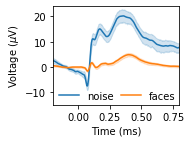

In [162]:
#fig, ax = plt.subplots(1, 1, figsize=(4.90, 1.8))
fig, ax = plt.subplots(1, 1, figsize=(2.45, 1.8))
sns.lineplot(data=erp_df, x="time", y="erp", hue="condition", ax=ax)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage ($\mu$V)")
ax.set_xlim(tmin, tmax)
ax.legend(loc='lower right', ncol=2, columnspacing=0.7,
          frameon=False, borderaxespad=0)
ax.set_ylim(-15, 24)

fig.tight_layout(pad=0)
fig.savefig("ERP-between-subjects.png", dpi=300)

### Correlations between brain regions

In [7]:
def get_atlas_info(template):
    atlas = "/usr/local/freesurfer/subjects/ANTS{}3T/mri/aparc+aseg.mgz".format(template)

    epi_img = nib.load(str(atlas))
    epi_img_data = epi_img.get_fdata()

    # zeroing non cortical regions
    no_regions, name_regions = list(zip(*mne.source_space._get_lut()))[:2]
    cortical_nos = [no for no, name in zip(no_regions, name_regions) if "ctx" in name]
    for no in np.unique(epi_img_data):
        if no not in cortical_nos:
            epi_img_data[epi_img_data == no] = 0

    vox2ras_tkr = epi_img.header.get_vox2ras_tkr()
    vox2ras = epi_img.header.get_vox2ras()

    pos_atlas = apply_trans(vox2ras_tkr, np.array(np.where(epi_img_data)).T)

    kdtree = KDTree(pos_atlas)
    
    return kdtree, vox2ras_tkr, vox2ras, epi_img_data

In [8]:
def load_sources(subject, template, template_info=None):
    
    if template_info is None:
        kdtree, vox2ras_tkr, vox2ras, epi_img_data = get_atlas_info(template)
    else:
        kdtree, vox2ras_tkr, vox2ras, epi_img_data = template_info
        
    sources = {}
    id_model = {}
    ts_model = {}
    for head_model in head_models:
        for source_model in source_models:
            model_type = (head_model, source_model)

            # Loading sources
            model_type = (head_model, source_model)
            file_name = 'source_{}_{}_{}_{}_noise.mat'.format(head_model, source_model, template, subject)
            sources[model_type] = read_mat(source_path + file_name)["sources"]
            sources[model_type]["pos"] += (vox2ras_tkr - vox2ras)[:3, 3]            

            # Find in what region each source falls in (or is the closest to)
            dist, points_inds = kdtree.query(sources[model_type]["pos"], 1)
            x, y, z = np.array(np.where(epi_img_data)).T[points_inds].T
            id_model[model_type] = epi_img_data[x, y, z]

            # Get the time series for each sources
            ts_model[model_type] = {}
            for id_ in np.unique(id_model[model_type]):
                region_sources = sources[model_type]["avg"]["pow"][id_ == id_model[model_type], :]
                ts_model[model_type][id_] = np.nanmean(region_sources, axis=0)   
                
    return sources, id_model, ts_model

In [9]:
def get_correlation_df(subject, template, template_info=None):
    
    if template_info is None:
        template_info = get_atlas_info(template)        
    
    sources, id_model, ts_model = load_sources(subject, template, template_info=template_info)
    
    model_types = list(product(head_models, source_models))
    dfs = []
    for model_type1, model_type2 in combinations(model_types, 2):
        id1s = []
        id2s = []
        corr = []
        for id1 in ts_model[model_type1]:
            for id2 in ts_model[model_type2]:
                id1s.append(id1)
                id2s.append(id2)
                corr.append(np.corrcoef([ts_model[model_type1][id1][int(-tmin*sfreq):], 
                                         ts_model[model_type2][id2][int(-tmin*sfreq):]])[0, 1])
                
        df = pd.DataFrame(dict(id1s=id1s, id2s=id2s, corr=corr))
        df["headmodel1"] = model_type1[0]
        df["headmodel2"] = model_type2[0] 
        df["sourcemodel1"] = model_type1[1]
        df["sourcemodel2"] = model_type2[1] 
        df["model1"] = model_type1[0] + "_" + model_type1[1]
        df["model2"] = model_type2[0] + "_" + model_type2[1] 
        df["model12"] = df["model1"] + "-" + df["model2"]
        df["intra"] = df["id1s"] == df["id2s"]
        df["template"] = template

        df["headmodel_diff"] = df["headmodel1"] != df["headmodel2"]
        df["sourcemodel_diff"] = df["sourcemodel1"] != df["sourcemodel2"]

        dfs.append(df)

    return pd.concat(dfs)

In [10]:
def save_template_corr(template):
    template_info = get_atlas_info(template)          
    dfs = []    
    for subject in tqdm(np.unique(erp_df.subject)):
        try:
            df = get_correlation_df(subject, template, template_info=template_info)
        except OSError:
            continue
        df["subject"] = subject
        dfs.append(df)

    corr_df = pd.concat(dfs)
    corr_df.to_csv("corr_sources_" + template + ".csv")


In [11]:
recompute = False

if recompute:
    for template in tqdm(templates):
        save_template_corr(template)

In [12]:
corr_df = []
for template in templates:
    corr_df.append(pd.read_csv("corr_sources_" + template + ".csv"))
corr_df = pd.concat(corr_df)
corr_df = corr_df.groupby(["model12", "id1s", "id2s", "intra", "template"]).mean().reset_index()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


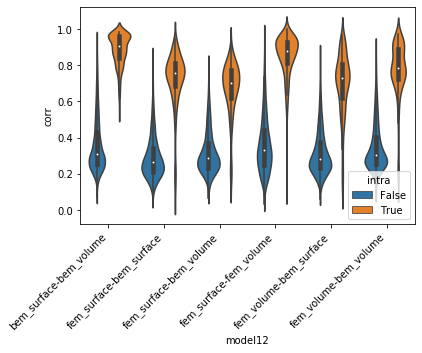

In [13]:
%matplotlib inline

import seaborn as sns
chart = sns.violinplot(y="corr", x="model12", hue="intra", split=False, 
                       data=corr_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart

In [14]:
model12_short_dict = {'bem_surface-bem_volume': 'BB-SV',
 'fem_surface-bem_surface':'FB-SS',
 'fem_surface-bem_volume': 'FB-SV',
 'fem_surface-fem_volume': 'FF-SV',
 'fem_volume-bem_surface': 'FB-VS',
 'fem_volume-bem_volume':  'FB-VV'}

corr_df["model12_short"] = [model12_short_dict[model12] for model12 in corr_df.model12]

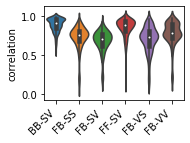

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(2.45, 1.8))
sns.violinplot(y="corr", x="model12_short", scale="width", data=corr_df[corr_df.intra], inner='box', ax=ax)

ax.set_xlabel("")
ax.set_ylabel("correlation")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

fig.tight_layout(pad=0)
fig.savefig("model_corr_violinplot.png", dpi=300)

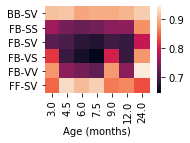

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(2.45, 1.8))
display_map = corr_df[corr_df.intra].groupby(["model12_short", "template"]).median().reset_index()
display_map = display_map.pivot_table(columns="template", index="model12_short", values="corr")
display_map = display_map[templates]
yticks = display_map.index
xticks = ["3.0", "4.5", "6.0", "7.5", "9.0", "12.0", "24.0"]
sns.heatmap(display_map, yticklabels=yticks, xticklabels=xticks, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel("")
#ax.set_yticklabels(g.get_yticklabels(), rotation = 0, verticalalignment='center');

fig.tight_layout(pad=0) 
fig.savefig("corr_heatmap.png", dpi=300)    

In [359]:
selected_contrast = 'fem_surface-bem_volume'

corr_df[(corr_df.intra) & (corr_df.model12 == selected_contrast)].groupby("id1s").mean().reset_index().sort_values("corr")

,id1s,id2s,intra,Unnamed: 0,corr,headmodel_diff,sourcemodel_diff,subject
13,1014.0,1014.0,True,907.571429,0.294081,True,True,671.032258
48,2014.0,2014.0,True,3357.714286,0.295299,True,True,671.032258
11,1012.0,1012.0,True,766.428571,0.349906,True,True,671.032258
31,1032.0,1032.0,True,2177.857143,0.423153,True,True,671.032258
66,2032.0,2032.0,True,4628.000000,0.457191,True,True,671.032258
...,...,...,...,...,...,...,...,...
3,1003.0,1003.0,True,211.714286,0.782974,True,True,671.032258
24,1025.0,1025.0,True,1683.857143,0.794076,True,True,671.032258
28,1029.0,1029.0,True,1966.142857,0.808791,True,True,671.032258
63,2029.0,2029.0,True,4416.285714,0.824378,True,True,671.032258


In [18]:
head_fact = {'bem_surface-bem_volume': 'BB',
 'fem_surface-bem_surface':'FB',
 'fem_surface-bem_volume': 'FB',
 'fem_surface-fem_volume': 'FF',
 'fem_volume-bem_surface': 'FB',
 'fem_volume-bem_volume':  'FB'}

source_fact = {'bem_surface-bem_volume': 'SV',
 'fem_surface-bem_surface':'SS',
 'fem_surface-bem_volume': 'SV',
 'fem_surface-fem_volume': 'SV',
 'fem_volume-bem_surface': 'SV',
 'fem_volume-bem_volume':  'VV'}


corr_df["source_fact"] = [source_fact[model12] for model12 in corr_df.model12]
corr_df["head_fact"] = [head_fact[model12] for model12 in corr_df.model12]

In [450]:
tmp = corr_df[corr_df.intra].groupby(["template", "source_fact", "head_fact"]).median().reset_index()
tmp = tmp[~((tmp.source_fact == "SV") & (tmp.head_fact == "FB"))]

formula = 'corr ~ C(template, Treatment(reference="2-0Years")) + C(source_fact, Treatment(reference="SV"))'
formula = formula + ' +  C(head_fact, Treatment(reference="FB"))'
mod = smf.ols(formula=formula, data=tmp)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   corr   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     4.319
Date:                Sun, 01 Nov 2020   Prob (F-statistic):             0.0385
Time:                        10:34:42   Log-Likelihood:                 71.390
No. Observations:                  28   AIC:                            -98.78
Df Residuals:                       6   BIC:                            -69.47
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================================
                                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                    0.7142      0.016     43.732      0.000       0.674       0.754
C(template, Treatment(reference="2-0Years"))[T.12-0Months]                                                  -0.1572      0.041     -3.851      0.008      -0.257      -0.057
C(template, Treatment(reference="2-0Years"))[T.3-0Months]                                                   -0.0872      0.041     -2.136      0.077      -0.187       0.013
C(template, Treatment(reference="2-0Years"))[T.4-5Months]                                                   -0.1654      0.041     -4.051      0.007      -0.265      -0.065
C(template, Treatment(reference="2-0Years"))[T.6-0Months]                                                   -0.1784      0.041     -4.368      0.005      -0.278      -0.078
C(template, Treatment(reference="2-0Years"))[T.7-5Months]                                                   -0.1825      0.041     -4.469      0.004      -0.282      -0.083
C(template, Treatment(reference="2-0Years"))[T.9-0Months]                                                   -0.0943      0.041     -2.309      0.060      -0.194       0.006
C(head_fact, Treatment(reference="FB"))[T.BB]                                                                0.2037      0.036      5.723      0.001       0.117       0.291
C(head_fact, Treatment(reference="FB"))[T.FF]                                                                0.1201      0.036      3.375      0.015       0.033       0.207
C(source_fact, Treatment(reference="SV"))[T.SS]                                                              0.1719      0.024      7.315      0.000       0.114       0.229
C(source_fact, Treatment(reference="SV"))[T.VV]                                                              0.2184      0.024      9.292      0.000       0.161       0.276
C(template, Treatment(reference="2-0Years"))[T.12-0Months]:C(head_fact, Treatment(reference="FB"))[T.BB]     0.1397      0.071      1.976      0.096      -0.033       0.313
C(template, Treatment(reference="2-0Years"))[T.3-0Months]:C(head_fact, Treatment(reference="FB"))[T.BB]      0.0791      0.071      1.118      0.306      -0.094       0.252
C(template, Treatment(reference="2-0Years"))[T.4-5Months]:C(head_fact, Treatment(reference="FB"))[T.BB]      0.1612      0.071      2.280      0.063      -0.012       0.334
C(template, Treatment(reference="2-0Years"))[T.6-0Months]:C(head_fact, Treatment(reference="FB"))[T.BB]      0.1513      0.071      2.139     

In [454]:
tmp

,template,source_fact,id1s,id2s,intra,Unnamed: 0,corr,headmodel_diff,sourcemodel_diff,subject
0,12-0Months,SV,1517.5,1517.5,True,2449.5,0.869988,False,True,671.032258
1,2-0Years,SV,1517.5,1517.5,True,2449.5,0.834356,False,True,671.032258
2,3-0Months,SV,1517.5,1517.5,True,2449.5,0.849082,False,True,671.032258
3,4-5Months,SV,1517.5,1517.5,True,2311.5,0.929153,False,True,671.032258
4,6-0Months,SV,1035.0,1035.0,True,2380.0,0.906082,False,True,671.032258
5,7-5Months,SV,1517.5,1517.5,True,2449.5,0.921501,False,True,671.032258
6,9-0Months,SV,1517.5,1517.5,True,2449.5,0.860124,False,True,671.032258


In [458]:
tmp = corr_df[corr_df.intra & (corr_df.head_fact == "FF")].groupby(["template", "id1s"]).median().reset_index()

formula = 'corr ~ template'
mod = smf.ols(formula=formula, data=tmp)
res = mod.fit()
table = sm.stats.anova_lm(res, typ=2)
table

,sum_sq,df,F,PR(>F)
template,0.600695,6.0,7.353535,1.544072e-07
Residual,6.535039,480.0,NaN,NaN


In [459]:
tmp = corr_df[corr_df.intra & (corr_df.head_fact == "BB")].groupby(["template", "id1s"]).median().reset_index()

formula = 'corr ~ template'
mod = smf.ols(formula=formula, data=tmp)
res = mod.fit()
table = sm.stats.anova_lm(res, typ=2)
table



,sum_sq,df,F,PR(>F)
template,0.048322,6.0,1.044056,0.39581
Residual,3.702660,480.0,NaN,NaN


In [356]:
corr_df[(corr_df.intra) & 
                       (corr_df.model12 == selected_contrast)]

,model12,id1s,id2s,intra,template,Unnamed: 0,corr,headmodel_diff,sourcemodel_diff,subject,model12_short,source_fact,head_fact
67770,fem_surface-bem_volume,1000.0,1000.0,True,12-0Months,0.0,0.706289,True,True,671.032258,FB-SV,SV,FB
67771,fem_surface-bem_volume,1000.0,1000.0,True,2-0Years,0.0,0.737159,True,True,671.032258,FB-SV,SV,FB
67772,fem_surface-bem_volume,1000.0,1000.0,True,3-0Months,0.0,0.773780,True,True,671.032258,FB-SV,SV,FB
67773,fem_surface-bem_volume,1000.0,1000.0,True,4-5Months,0.0,0.644298,True,True,671.032258,FB-SV,SV,FB
67774,fem_surface-bem_volume,1000.0,1000.0,True,6-0Months,0.0,0.723831,True,True,671.032258,FB-SV,SV,FB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101650,fem_surface-bem_volume,2035.0,2035.0,True,3-0Months,4899.0,0.737594,True,True,671.032258,FB-SV,SV,FB
101651,fem_surface-bem_volume,2035.0,2035.0,True,4-5Months,4623.0,0.650246,True,True,671.032258,FB-SV,SV,FB
101652,fem_surface-bem_volume,2035.0,2035.0,True,6-0Months,4760.0,0.673047,True,True,671.032258,FB-SV,SV,FB
101653,fem_surface-bem_volume,2035.0,2035.0,True,7-5Months,4899.0,0.671520,True,True,671.032258,FB-SV,SV,FB


In [362]:

tmp = corr_df[(corr_df.intra) & (corr_df.model12 == selected_contrast)].groupby("id1s").mean().reset_index().sort_values("corr")

largest_corr = tmp["id1s"].values[-1] 
smallest_corr = tmp["id1s"].values[0]

largest_corr_rho = tmp["corr"].values[-1] 
smallest_corr_rho = tmp["corr"].values[0]


### ERP for regions with highest and lowest correlation between the surface and the BEM models

In [363]:
def compute_template_sources_ts(template):
    dfs = []    
    for subject in tqdm(np.unique(erp_df.subject), leave=False):
        try:
            sources, id_model, ts_model = load_sources(subject, template)   
        except OSError:
            continue

        for head_model in head_models:
            for source_model in source_models:
                model_type = (head_model, source_model)            
                df = pd.DataFrame(ts_model[model_type]).reset_index().melt(id_vars=["index"])
                df.columns = ["time_id", "no_region", "ersp"]
                df["template"] = template
                df["subject"] = subject        
                df["head_model"] = head_model        
                df["source_model"] = source_model        
                dfs.append(df)

    pd.concat(dfs).to_csv("ts_sources_" + template + ".csv")  

recompute = False
if recompute:
    for template in tqdm(templates, leave=False):
        compute_template_sources_ts(template) 

In [ ]:
recompute = False

if recompute:
    dfs = []
    for path in tqdm(list(Path(erp_path).glob('tlck_*_noise.mat'))):
        subject = parse('tlck_{}_noise.mat', str(path.name)).fixed[0]

        erp  = read_mat(path)
        time = erp["tlck_noise"]["time"]
        labels = erp["tlck_noise"]["label"]
        try:
            channel_ind = erp["tlck_noise"]["elec"]['label'].index("E75")
        except ValueError:
            continue
            
        # epochs, channels, times
        erp  = erp["tlck_noise"]["trial"]
        
        if len(erp.shape) == 3:
            # This condition must be checked because in rare occasion
            # only 1 epoch is available and in this case only two axes are present
            erp = erp.mean(0)
        
        erp = mne.filter.filter_data(erp, 500.0, l_freq=0.0, h_freq=35.0, 
                                     verbose=False, method='iir')
        
        df = pd.DataFrame(erp)
        df.columns = time
        df.index = labels
        df = df.reset_index().melt(id_vars="index")
        df.columns = ["channel", "time", "erp"]
        df["subject"] = subject   
        dfs.append(df)    

    erp_noise_df = pd.concat(dfs)
    erp_noise_df["time"] = np.round(erp_noise_df.time.astype(float) * 500.0)/500.0
    erp_noise_df.to_csv("erp_noise_mean.csv")
    
    
erp_noise_df = pd.read_csv("erp_noise_mean.csv")

In [24]:
group_factors = ["time_id", "head_model", "source_model", "no_region"]
source_ts_df = pd.concat([pd.read_csv("ts_sources_" + template + ".csv").groupby(group_factors).mean().reset_index()
                          for template in templates]) 

In [ ]:
tmin_win = 0.15
tmax_win = 0.20

In [340]:
source_ts_df

,time_id,head_model,source_model,no_region,Unnamed: 0,ersp,subject
0,0,bem,surface,1000.0,0.0,0.368528,671.032258
1,0,bem,surface,1001.0,500.0,3.115762,671.032258
2,0,bem,surface,1002.0,1000.0,0.442373,671.032258
3,0,bem,surface,1003.0,1500.0,1.794382,671.032258
4,0,bem,surface,1005.0,2000.0,1.311412,671.032258
...,...,...,...,...,...,...,...
139995,499,fem,volume,2031.0,32999.0,5.892826,671.032258
139996,499,fem,volume,2032.0,33499.0,5.262220,671.032258
139997,499,fem,volume,2033.0,33999.0,0.893001,671.032258
139998,499,fem,volume,2034.0,34499.0,1.469668,671.032258


In [460]:
def plot_region_ERSP(no_region, source_ts_df, corr_val, ax, add_labels):

    t = np.arange(-0.2, 0.8, 0.002)

    label_dict = {}
    for head_model in head_models:
        for source_model in source_models:
            ts = source_ts_df[source_ts_df.no_region == no_region]
            ts = ts[(ts.head_model == head_model) & (ts.source_model == source_model)]
            model_type = (head_model, source_model)
            label_dict[model_type] = head_model.upper() + "-" + source_model

            ts = ts.groupby("time_id").mean().ersp
            try:
                ts /= ts.std()
                ts = mne.filter.filter_data(ts, sfreq, l_freq=0.0, h_freq=50.0, verbose=False, method='iir')
                ax.plot(t, ts, label=label_dict[model_type] if add_labels else "")
            except KeyError:
                continue
                
    erp = erp_df.groupby("time").mean()["erp"]
    ax.plot(t, erp/erp.std(), label="ERP" if add_labels else "")                

    ax.set_xlim(0, 0.8)
    ax.set_xlabel("Time (s)")
    if add_labels:
        ax.set_ylabel("Normalized amplitude")
    else:
        ax.set_ylabel("")

    no_regions, name_regions = list(zip(*mne.source_space._get_lut()))[:2]
    region_name = name_regions[no_regions.index(int(no_region))]
    ax.text(0.5, 0.1, "Region: " + region_name.replace("ctx-", ""), 
            horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes,
            size=12)

    ax.text(0.01, 0.98, r"$\rho$=" + str(corr_val), 
            horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes,
            size=12)

    ymin, ymax = plt.ylim()    
    ax.axvline(x=tmin_win, linestyle="--", color="k", alpha=0.1)
    ax.axvline(x=tmax_win, linestyle="--", color="k", alpha=0.1)
    ax.fill_between([tmin_win, tmax_win], [-100, -100], [100, 100], facecolor='k', alpha=0.1)
    plt.ylim(ymin, ymax)  

/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-di

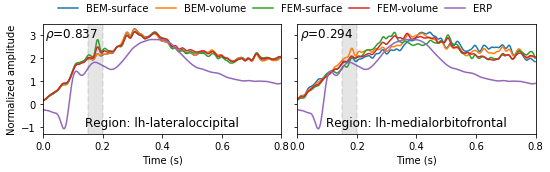

In [461]:
fig, axes = plt.subplots(1, 2, figsize=(7.45, 2.2), sharey=True)

plot_region_ERSP(largest_corr, source_ts_df, np.round(largest_corr_rho, 3), axes[0], True)     
plot_region_ERSP(smallest_corr, source_ts_df, np.round(smallest_corr_rho, 3), axes[1], False)    

fig.tight_layout(pad=0, rect=(0, 0, 1, 0.89))
fig.legend(ncol=5, columnspacing=0.7, loc='upper center',
           frameon=False, borderaxespad=0)

fig.savefig("ERP_highest_and_lowest_correlations.png", dpi=300)    

In [368]:
source_ts_df

,time_id,head_model,source_model,no_region,Unnamed: 0,ersp,subject
0,0,bem,surface,1000.0,0.0,0.368528,671.032258
1,0,bem,surface,1001.0,500.0,3.115762,671.032258
2,0,bem,surface,1002.0,1000.0,0.442373,671.032258
3,0,bem,surface,1003.0,1500.0,1.794382,671.032258
4,0,bem,surface,1005.0,2000.0,1.311412,671.032258
...,...,...,...,...,...,...,...
139995,499,fem,volume,2031.0,32999.0,5.892826,671.032258
139996,499,fem,volume,2032.0,33499.0,5.262220,671.032258
139997,499,fem,volume,2033.0,33999.0,0.893001,671.032258
139998,499,fem,volume,2034.0,34499.0,1.469668,671.032258


In [370]:
group_factors = ["time_id", "head_model", "source_model", "no_region", "template"]
source_ts_template_df = pd.concat([pd.read_csv("ts_sources_" + template + ".csv").groupby(group_factors).mean().reset_index()
                          for template in templates]) 

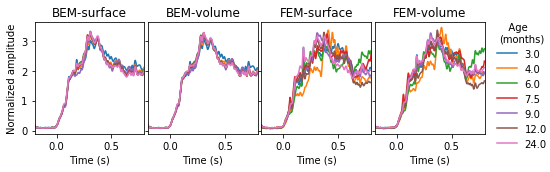

In [473]:
fig, axes = plt.subplots(1, 4, figsize=(7.45, 2.2), sharey=True, sharex=True)

no_region = largest_corr

t = np.arange(-0.2, 0.8, 0.002)

for template in templates:
    for (head_model, source_model), ax in zip(product(head_models, source_models), axes):
        ts = source_ts_template_df[source_ts_df.no_region == no_region]
        ts = ts[ts.template == template]
        ts = ts[(ts.head_model == head_model) & (ts.source_model == source_model)]
        model_type = (head_model, source_model)

        ts = ts.groupby("time_id").mean().ersp
        try:
            ts /= ts.std()
            ts = mne.filter.filter_data(ts, sfreq, l_freq=0.0, h_freq=50.0, verbose=False, method='iir')
            ax.plot(t, ts, label=template_ages[template] if model_type == ("bem", "surface") else "")
        except KeyError:
            continue

        ax.set_xlim(-0.2, 0.8)
        
        ax.set_title(head_model.upper() + "-" + source_model)
        ax.set_xlabel("Time (s)")
        
axes[0].set_ylabel("Normalized amplitude")



fig.tight_layout(pad=0, rect=(0, 0, 0.89, 1))
leg = fig.legend(ncol=1, columnspacing=0.7, loc='right',
           frameon=False, borderaxespad=0, title="   Age\n(months)")


fig.savefig("ERSP_across_templates.png", dpi=300)    

### Plotting the topomap

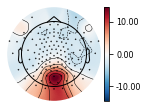

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(2.45, 1.6))

montage = mne.channels.make_standard_montage("GSN-HydroCel-128")

tmp_df = erp_noise_df[(erp_noise_df["time"] > tmin_win) & (erp_noise_df["time"] < tmax_win)]
tmp_df = tmp_df.groupby("channel").mean()
plot_values_topomap(tmp_df["erp"].to_dict(), montage, ax, colorbar=True, cmap='RdBu_r', vmin=None, vmax=None)

im = ax.images        
cb = im[-1].colorbar  
cb.ax.tick_params(labelsize=8)

fig.tight_layout()
plt.savefig("topomap.png", dpi=300)

### Source amplitude distribution

In [121]:
def compute_template_dipole_sources(erp_df, template, tmin_win, tmax_win):
    dfs = []    
    for subject in tqdm(np.unique(erp_df.subject), leave=False):
        try:
            sources, id_model, ts_model = load_sources(subject, template)   
        except OSError:
            continue
        
        for head_model in head_models:
            for source_model in source_models:
                model_type = (head_model, source_model)   
                inds = (sources[model_type]["time"] > tmin_win) & (sources[model_type]["time"] < tmax_win)

                inside = sources[model_type]["inside"]
                df = pd.DataFrame(sources[model_type]["avg"]["pow"][inside][:, inds]).reset_index().melt(id_vars="index")
                df.columns = ["vertice", "time", "ersp"]
                df = df.groupby("vertice").mean()[["ersp"]] # Averaging across time
                df["template"] = template
                df["subject"] = subject        
                df["head_model"] = head_model        
                df["source_model"] = source_model        
                dfs.append(df)

    pd.concat(dfs).to_csv("dipole_sources_" + template + ".csv")

In [122]:
recompute = False

if recompute:
    for template in tqdm(templates, leave=False):
        compute_template_dipole_sources(erp_df, template, tmin_win, tmax_win)

In [123]:
dipole_df = pd.concat([pd.read_csv("dipole_sources_" + template + ".csv") for template in templates])

In [463]:
ersp_df = dipole_df.copy()
ersp_df = ersp_df.groupby(["vertice", "template", "head_model", "source_model"]).mean().reset_index()
ersp_df["ersp"] = np.log10(ersp_df["ersp"])
ersp_df["model"] = [hm.upper() + "-" + sm for hm, sm in zip(ersp_df["head_model"], ersp_df["source_model"])]

/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dime

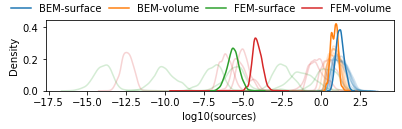

In [467]:
#fig, ax = plt.subplots(1, 1, figsize=(3.75, 1.6))
fig, ax = plt.subplots(1, 1, figsize=(5.35, 1.6))


models = sorted(np.unique(ersp_df.model))
palette = [(r, g, b, 0.2) for r, g, b in sns.color_palette()[:len(models)]]
  
for template in np.unique(ersp_df.template):
    g = sns.kdeplot(data=ersp_df[ersp_df.template == template], x="ersp", hue="model", 
                    hue_order=models, ax=ax,
                    palette=palette, legend=False)
    

g = sns.kdeplot(data=ersp_df.groupby(["model", "vertice"]).mean().reset_index(), 
                x="ersp", hue="model", 
                hue_order=models, ax=ax,
                palette=sns.color_palette()[:len(models)], legend=True)    

g.legend_.set_title("")

sources_lim_1 = {}
sources_lim_99 = {}

for model_type_str, color in zip(models, sns.color_palette()):    
    head_model, source_model = model_type_str.split("-")
    ersp = ersp_df[(ersp_df.head_model == head_model.lower()) & 
                   (ersp_df.source_model == source_model)]["ersp"]
    

ax.set_xlabel("log10(sources)")
ax.legend_.set_visible(False)


fig.tight_layout(pad=0, rect=(0, 0, 0.999, 0.88))
fig.legend(g.legend_.legendHandles, [t.get_text() for t in g.legend_.texts], ncol=4, 
           columnspacing=0.7, loc='upper center',
           frameon=False, borderaxespad=0)    


#legend = fig.legend()
#legend.set_label = ax.legend_.get_label()


plt.savefig("source_amplitude_distribution.png", dpi=300)

### Plotting sources on meshes

In [165]:
def get_pial_mesh(template, face_count = 20000):
    mesh_pattern = "/usr/local/freesurfer/subjects/ANTS{}3T/surf/{}.pial"
    mesh = trimesh.util.concatenate([trimesh.Trimesh(*read_geometry(mesh_pattern.format(template, hemi))) 
                                     for hemi in ["lh", "rh"]])

    open3d_mesh = open3d.geometry.TriangleMesh(vertices=open3d.utility.Vector3dVector(mesh.vertices),
                                               triangles=open3d.utility.Vector3iVector(mesh.faces))

    mesh = open3d_mesh.simplify_quadric_decimation(int(face_count))
    return np.asarray(mesh.vertices), np.asarray(mesh.triangles)
    

In [166]:
def get_source_model(template, source_model):
    path = "/home/christian/synchedin/infants_atlas_modeling/fieldtrip/single_subject_analysis/"
    source_model_dict = read_mat(path + "sourcemodel_{}_{}.mat".format(source_model, template))["sourcemodel"]

    kdtree, vox2ras_tkr, vox2ras, epi_img_data = get_atlas_info(template)
    source_model_dict["pos"] += (vox2ras_tkr - vox2ras)[:3, 3]           

    return source_model_dict

In [167]:
def get_template_source_meshes(template_dipole_df, template):
    vertices, triangles = get_pial_mesh(template, face_count = 20000)

    meshes = {}
    for model_type, df in template_dipole_df.groupby(["head_model", "source_model"]):
        head_model, source_model = model_type
    
        source_model_dict = get_source_model(template, source_model)   
        inside = source_model_dict["inside"]
        sourcemodel_kdtree = KDTree(source_model_dict["pos"][inside, :])
        
        meshes[model_type] = trimesh.Trimesh(vertices=vertices, faces=triangles)        
        points = sourcemodel_kdtree.query(meshes[model_type].vertices, 1)[1]     
        # Trimesh does not preserve vertice order. So the following line cannot be used:
        #points = sourcemodel_kdtree.query(vertices, 1)[1]
        #assert(np.all(meshes[model_type].vertices == vertices))
        
        mean_ersp = df.groupby("vertice").mean()["ersp"].sort_index().values[inside]    

        #xmin = np.percentile(mean_ersp, 1)
        #xmax = np.percentile(mean_ersp, 99)
        #norm = mpl.colors.Normalize(vmin=xmin, vmax=xmax)
        perc = np.percentile(mean_ersp, np.linspace(75, 100, 100))
        mean_ersp = np.digitize(mean_ersp, perc)
        norm = mpl.colors.Normalize(vmin=mean_ersp.min(), vmax=mean_ersp.max())

        cmap = plt.get_cmap("Reds")
        colors = cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(mean_ersp[points])
        meshes[model_type].visual.vertex_colors = np.round(colors*255).astype(np.uint8)
            
    return meshes

In [168]:
meshes = {}
for template in tqdm(templates):
    meshes[template] = get_template_source_meshes(dipole_df[dipole_df.template == template], template)

In [186]:
def show_mesh(meshes, model_type, angle_x, angle_y, angle_z, ax=None, resolution=(1200, 1200)):
    mesh = meshes[model_type].copy()
    Re = trimesh.transformations.euler_matrix(angle_x, angle_y, angle_z, 'rxyz')
    mesh.apply_transform(Re)

    scene = pyrender.Scene(ambient_light=[0.0, 0.0, 0.0],
                               bg_color=[1.0, 1.0, 1.0], )
    scene.add(pyrender.Mesh.from_trimesh(mesh))
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 4.0, aspectRatio=1.0)

    camera_pose = np.eye(4)
    camera_pose[:3,3] = [0, 0, 240]
    scene.add(camera, pose=camera_pose)

    ligth_poses = [np.array([[-0.   , -0.866,  0.5  ,  0.   ],
                           [ 1.   , -0.   , -0.   ,  0.   ],
                           [ 0.   ,  0.5  ,  0.866,  0.   ],
                           [ 0.   ,  0.   ,  0.   ,  1.   ]]),
                   np.array([[ 0.866,  0.433, -0.25 ,  0.   ],
                           [-0.5  ,  0.75 , -0.433,  0.   ],
                           [ 0.   ,  0.5  ,  0.866,  0.   ],
                           [ 0.   ,  0.   ,  0.   ,  1.   ]]),
                   np.array([[-0.866,  0.433, -0.25 ,  0.   ],
                           [-0.5  , -0.75 ,  0.433,  0.   ],
                           [ 0.   ,  0.5  ,  0.866,  0.   ],
                           [ 0.   ,  0.   ,  0.   ,  1.   ]])]


    for pose in ligth_poses:
        light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], 
                                          intensity=1.0)
        scene.add(light, pose=pose)
    r = pyrender.OffscreenRenderer(*resolution)
    color, depth = r.render(scene)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.axis('off')
    
    ind_ax0 = np.where(np.any(np.any(color != 255, axis=2), axis=1))[0]
    ind_ax1 = np.where(np.any(np.any(color != 255, axis=2), axis=0))[0]

    ax.imshow(color[ind_ax0[0]:(ind_ax0[-1]+1), ind_ax1[0]:(ind_ax1[-1]+1), :])


In [203]:

def plot_source_all_templates(angle_x, angle_y, angle_z, file_name):
    
    fig, axes = plt.subplots(len(meshes), 4, figsize=(3.7, len(meshes)*1.0))

    for template, ax_row in zip(templates, axes):
        for (head_model, source_model), ax in zip(list(product(head_models, source_models)), ax_row):
            show_mesh(meshes[template], (head_model, source_model), angle_x, angle_y, angle_z, ax)
            if template == '3-0Months':
                ax.text(0.5, 1.2, head_model[0].upper() + "-" + source_model[0].upper(), 
                        horizontalalignment='center',
                        verticalalignment='center', transform=ax.transAxes,
                        size=12)

            #ax.set_xlim(100, 1100)
            if (head_model, source_model) == ("bem", "surface"):
                #ax.set_ylabel(template)
                #ax.yaxis.set_visible(True)

                ax.text(-0.2, 0.5, template_ages[template], horizontalalignment='center',
                        verticalalignment='center', transform=ax.transAxes,
                        rotation=90, size=12)

    fig.tight_layout()
    plt.savefig(file_name, dpi=300)

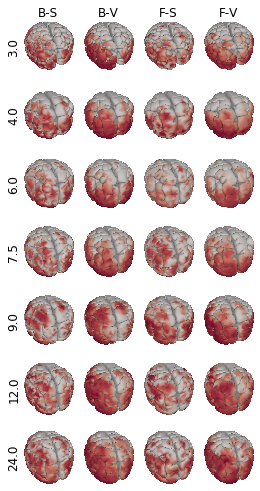

In [204]:
plot_source_all_templates(-np.pi/4, 0, np.pi/10, "left_back_sources.png")

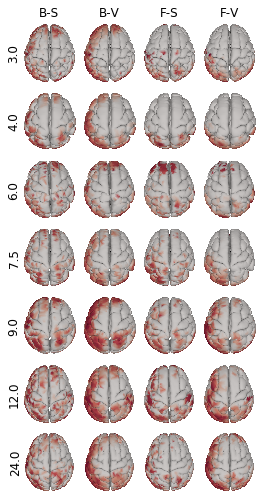

In [205]:
plot_source_all_templates(0, 0, 0, "top_sources.png")

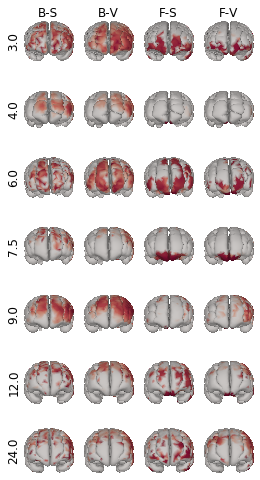

In [206]:
plot_source_all_templates(-np.pi/2, 0, np.pi, "front_sources.png")

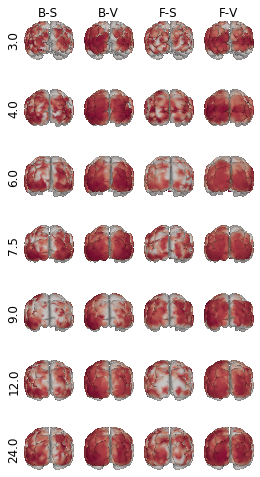

In [207]:
plot_source_all_templates(-np.pi/2, 0, 0, "back_sources.png")